In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
above = '../../../'
data = pd.read_pickle(above + 'post_eda.pkl') #('merged-sales-val-macro-dem-crime.pkl')

In [3]:
categorical_features_mask = data.dtypes == 'object'
categorical_features = data.columns[categorical_features_mask]
print(categorical_features)

Index([], dtype='object')


In [4]:
numeric_features_mask = data.dtypes != 'object'
numeric_features = data.columns[numeric_features_mask]
print(numeric_features)

Index(['s_borough', 's_zipcode', 's_total_units', 's_year_built',
       's_building_class_at_sale', 's_sale_price', 's_sale_date', 's_bbl',
       'v_stories', 'v_fullval',
       ...
       'd_households_from_100000_to_149999_pct',
       'd_households_from_150000_to_199999',
       'd_households_from_150000_to_199999_pct', 'd_households_200000_or_more',
       'd_households_200000_or_more_pct', 'd_median_household_income_dollars',
       'd_mean_household_income_dollars', 'a_count', 'c_count',
       'imputed_land_area'],
      dtype='object', length=126)


In [5]:
cat = len(categorical_features)
num = len(numeric_features)
print('Total Features: ', cat, 'categorical', '+',
      num, 'numerical', '=', cat+num, 'features')

Total Features:  0 categorical + 126 numerical = 126 features


In [6]:
corr_matrix = data.corr() #data.loc[:, numeric_col_mask].corr()

<AxesSubplot:>

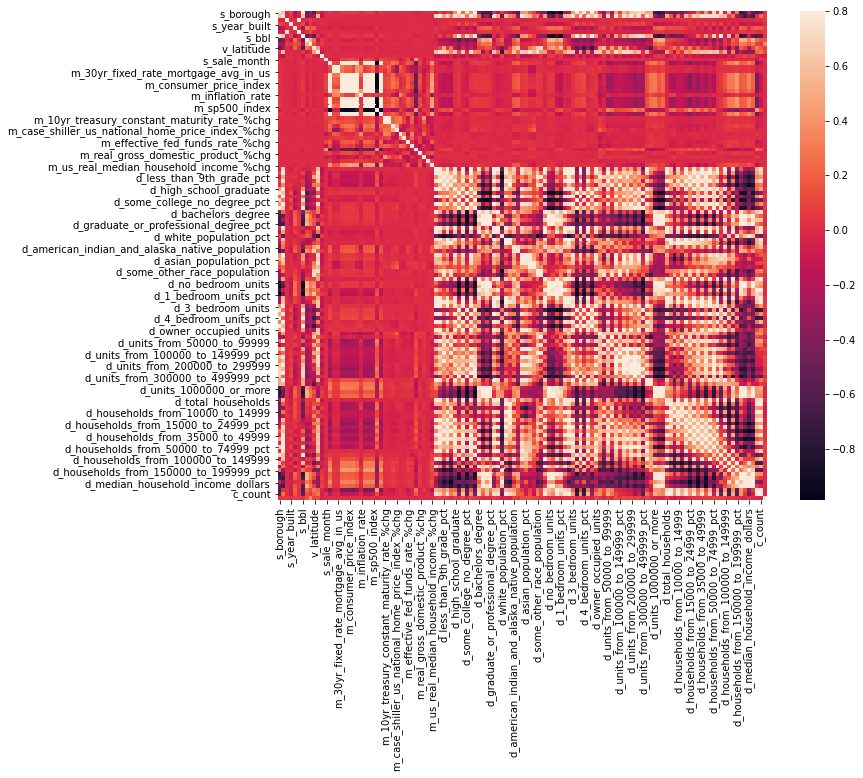

In [7]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.8, square=True)

In [8]:
corr_with_target = corr_matrix['s_sale_price']
print(np.abs(corr_with_target).sort_values(ascending=False).head(40))
print()
print(np.abs(corr_with_target).sort_values(ascending=False).tail(10))

s_sale_price                                          1.000000
s_total_units                                         0.786285
v_fullval                                             0.107169
d_high_school_graduate_pct                            0.063314
imputed_land_area                                     0.063177
d_no_bedroom_units_pct                                0.062775
d_units_1000000_or_more_pct                           0.062711
d_households_200000_or_more                           0.062584
d_graduate_or_professional_degree_pct                 0.061946
d_no_bedroom_units                                    0.061940
d_median_housing_price                                0.060864
d_households_200000_or_more_pct                       0.060748
d_associates_degree_pct                               0.059580
d_bachelors_degree_pct                                0.058715
d_mean_household_income_dollars                       0.058168
s_bbl                                                 0

In [9]:
k = 10
top_k_corr_features = np.abs(corr_with_target).sort_values(ascending=False).head(k).index.tolist()
print(corr_with_target[top_k_corr_features])

s_sale_price                             1.000000
s_total_units                            0.786285
v_fullval                                0.107169
d_high_school_graduate_pct              -0.063314
imputed_land_area                        0.063177
d_no_bedroom_units_pct                   0.062775
d_units_1000000_or_more_pct              0.062711
d_households_200000_or_more              0.062584
d_graduate_or_professional_degree_pct    0.061946
d_no_bedroom_units                       0.061940
Name: s_sale_price, dtype: float64


In [10]:
data_narrowed = data[top_k_corr_features]

<AxesSubplot:>

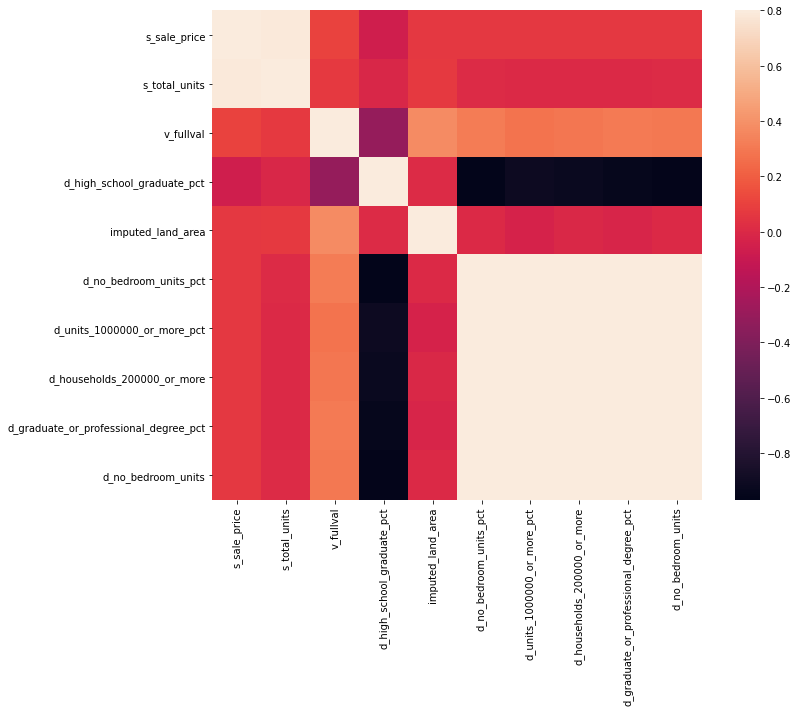

In [11]:
top_k_corr_matrix = data[top_k_corr_features].corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(top_k_corr_matrix, vmax=.8, square=True)

Forward Selection

In [98]:
from sklearn.model_selection import KFold
from sklearn import linear_model


def runXVal_LogLoss(cv, X_sub, Y_tr):
    '''
    Runs LR cross validation with no regularization, returns mean and standard error of mean
    '''
    ll = []; 
    for train_index, test_index in cv.split(X_sub):
        X_tr_f = X_sub.iloc[train_index]
        X_va_f = X_sub.iloc[test_index]
        Y_tr_f = Y_tr.iloc[train_index]
        Y_va_f = Y_tr.iloc[test_index]

        lr = linear_model.LogisticRegression()
        lr.fit(X_tr_f, Y_tr_f)
        P = lr.predict_proba(X_va_f)[:,1]
        
        ll.append(-1*(((Y_va_f==1)*np.log(P)+(Y_va_f==0)*np.log(1-P)).mean()))

    return [np.array(ll).mean(), np.array(ll).std()/np.sqrt(len(ll))]
        
def LrForward_LogLoss(X_tr, Y_tr, cv):
    '''
    Runs cross-validated stepwise selection
    Does not pick the best features, but returns data
    Returns a dictionary that shows at each k: [feature set], x-validated mean, x-validated var 
    For each loop, chooses the feature with best mean+1stderr
    '''
    results = {}
    curr_best = set([])
    cand_list = set(X_tr.columns.values)
    k = 1
    
    while (len(cand_list)>0):
        best_mu = 10**10; best_serr = 10**10; 
        for f in cand_list:
            use_x = list(curr_best)+[f]
            mu, serr = runXVal_LogLoss(cv, X_tr[use_x], Y_tr)
            if ((mu + serr) < (best_mu + best_serr)):
                best_mu = mu
                best_serr = serr
                best_f = f
        curr_best.add(best_f) #Add the best feature to the curr_best_set
        cand_list = cand_list.difference(curr_best) #Remove the best feature from the candidate set
        results[k] = [list(curr_best), best_mu, best_serr]
        k+=1
        
    return results
            

In [99]:
#Run the forward selection
label = 's_sale_price'
cv = KFold(n_splits=10)
r = LrForward_LogLoss(data_narrowed.drop(label,1), data_narrowed[label], cv)

MemoryError: Unable to allocate 83.6 GiB for an array with shape (361611, 31016) and data type int64

In [ ]:
#Now plot the incremental results
ks = []; mus = []; serrs = [];
for i in range(len(r.keys())):
    ks.append(i+1)
    mus.append(r[i+1][1])
    serrs.append(r[i+1][2])

    
best_1serr = min(np.array(mus) + np.array(serrs))
plt.clf()
plt.plot(ks, mus, 'b.-', label = 'LL of Set k')
plt.plot(ks, np.array(mus) + np.array(serrs), 'k+-')
plt.plot(ks, np.array(mus) - np.array(serrs), 'k--')
plt.plot(ks, np.ones(len(ks))*best_1serr, 'r', label ='1 std err rule')

plt.xlim([1,11])

plt.title('Stepwise Forward Feature Selection')
plt.xlabel('Greedily Selected Subset of Size k')
plt.ylabel('X Validated LogLoss')
    
plt.legend(loc=1, ncol=2)
plt.show()

SVD

In [54]:
data_pca = data.copy()
data_pca.drop(["s_sale_date"], axis =1, inplace=True)
# normalize data
data_pca_norm = (data_pca - data_pca.mean()) / data_pca.std()

In [55]:
import numpy as np
from sklearn.decomposition import PCA

# pca = PCA(n_components=50)
# pca.fit(data_scaled)
# PCA
pca = PCA(n_components=50)
#pca.fit_transform(data_pca_norm)

In [62]:
pca.components_

array([[-5.58977797e-02, -1.54334046e-01,  3.13082328e-04, ...,
        -5.46458863e-02, -8.18338458e-02, -1.04363271e-02],
       [-1.52409760e-01, -2.72355595e-02,  1.96250154e-03, ...,
         1.41477500e-01,  1.50487193e-01,  1.56323991e-03],
       [-1.17659320e-01, -8.83926926e-02,  6.77847269e-03, ...,
         1.06045085e-01,  5.71994181e-02, -1.45714187e-02],
       ...,
       [-6.11251448e-03, -3.26340458e-02,  2.34895864e-04, ...,
         1.43112032e-01,  4.93411812e-02, -4.63222365e-04],
       [-2.35062361e-02, -8.18924721e-02, -1.08944339e-03, ...,
         1.93933877e-02, -3.56084914e-02,  8.88897435e-05],
       [-1.85601570e-02, -5.34276036e-02,  3.16787888e-04, ...,
        -1.97123660e-03, -1.78676725e-01, -1.32506602e-04]])

In [60]:
pca.fit(data_pca_norm)
#Get the components from transforming the original data.
scores = pca.transform(data_pca_norm)
# Reconstruct from the 50 dimensional scores 
reconstruct = pca.inverse_transform(scores)
#The residual is the amount not explained by the first 50 components
residual=data_pca_norm-reconstruct

In [61]:
residual

,s_borough,s_zipcode,s_total_units,s_year_built,s_building_class_at_sale,s_sale_price,s_bbl,v_stories,v_fullval,v_latitude,...,d_households_from_100000_to_149999_pct,d_households_from_150000_to_199999,d_households_from_150000_to_199999_pct,d_households_200000_or_more,d_households_200000_or_more_pct,d_median_household_income_dollars,d_mean_household_income_dollars,a_count,c_count,imputed_land_area
0,-0.045828,-0.021235,0.000735,0.000050,0.000199,-0.000799,-0.050675,-0.000346,-0.000740,-0.010886,...,0.105718,0.068234,-0.032345,-0.023260,-0.068611,-0.018784,-0.024153,-0.018157,-0.005982,0.000254
1,-0.045933,-0.027235,0.000741,0.000058,0.000208,-0.000791,-0.049511,-0.000347,-0.000931,-0.011635,...,0.105220,0.068498,-0.032064,-0.023621,-0.068937,-0.019244,-0.024479,-0.017509,-0.005979,0.000296
2,-0.045716,-0.023878,0.000736,0.000055,0.000199,-0.000794,-0.051502,-0.000344,-0.000829,-0.011235,...,0.105980,0.068289,-0.032558,-0.023253,-0.068736,-0.018642,-0.024186,-0.018161,-0.005882,0.000275
3,-0.045760,-0.032809,0.000744,0.000067,0.000211,-0.000781,-0.050659,-0.000347,-0.001114,-0.012365,...,0.105363,0.068647,-0.032169,-0.023739,-0.069153,-0.019246,-0.024628,-0.017405,-0.005722,0.000339
4,-0.045949,-0.009230,0.000707,0.000031,0.000197,-0.000796,-0.039860,-0.000320,-0.000362,-0.008790,...,0.105310,0.068275,-0.030986,-0.022546,-0.067460,-0.018291,-0.022892,-0.020034,-0.006976,0.000164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337937,0.012575,-0.001036,-0.000070,0.000034,0.000156,0.000193,0.036326,0.000695,-0.000101,0.000452,...,0.081077,-0.060551,-0.071027,-0.018005,-0.028296,-0.034752,-0.031977,0.165005,-0.207579,-0.000642
337938,0.012326,0.004371,-0.000072,0.000025,0.000154,0.000183,0.038013,0.000695,0.000078,0.001167,...,0.080884,-0.060688,-0.070949,-0.017933,-0.028155,-0.034819,-0.031881,0.165027,-0.207839,-0.000685
337939,0.012205,0.005784,-0.000071,0.000024,0.000150,0.000179,0.037055,0.000694,0.000123,0.001302,...,0.081321,-0.060726,-0.071472,-0.017761,-0.028174,-0.034538,-0.031819,0.164815,-0.207568,-0.000694
337940,0.011538,0.013180,-0.000072,0.000010,0.000154,0.000162,0.041631,0.000693,0.000373,0.002304,...,0.080517,-0.060813,-0.071125,-0.017880,-0.028142,-0.035013,-0.031859,0.165380,-0.208095,-0.000757


In [ ]:
# Dump components relations with features:
print(pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2']))

In [53]:
n_components = 50
pd.DataFrame(pca.transform(data_pca_norm), columns=['PCA%i' % i for i in range(n_components)], index=data_pca_norm.index)

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA40,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49
0,-1.627286,-4.984815,13.313241,1.668316,0.362805,5.473391,0.010658,-0.425749,1.743333,0.038936,...,1.052770,0.098510,-0.204693,0.608583,-0.000296,0.113371,0.634032,-0.217708,-0.379705,-0.098103
1,-1.592674,-4.871038,13.387784,1.671842,0.416659,5.492028,0.007954,-0.294928,1.758740,-0.175471,...,1.048356,0.100076,-0.205907,0.607195,0.000669,0.115876,0.635786,-0.216497,-0.376792,-0.097763
2,-1.624341,-4.991773,13.302221,1.661042,0.358534,5.473312,0.011943,-0.400773,1.740871,0.060829,...,1.053839,0.099107,-0.203907,0.608420,-0.000224,0.114231,0.634240,-0.217464,-0.379835,-0.097541
3,-1.589376,-4.859276,13.394911,1.669539,0.417753,5.490983,0.006297,-0.239390,1.762981,-0.208077,...,1.047372,0.102303,-0.205512,0.606545,0.000952,0.117940,0.637155,-0.215569,-0.375659,-0.097265
4,-1.760383,-4.967057,13.271826,1.698353,0.497297,5.520013,0.025860,-0.451856,1.757094,0.079935,...,1.050186,0.061155,-0.193280,0.625637,0.020630,0.127882,0.637476,-0.220722,-0.387814,-0.102231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337937,11.661453,-9.543783,-5.646039,2.983374,-3.676359,1.782063,0.591774,0.245046,-1.445052,0.231313,...,-0.428670,-0.148871,0.182373,-0.363524,0.725271,0.018514,0.250642,-0.097087,-0.040682,0.135129
337938,11.663525,-9.542246,-5.641415,2.986328,-3.670260,1.783240,0.592045,0.256413,-1.443443,0.229377,...,-0.427726,-0.150495,0.181646,-0.363564,0.724641,0.016291,0.249498,-0.097577,-0.041492,0.134524
337939,11.643675,-9.632331,-5.704050,2.975938,-3.735391,1.763907,0.593046,0.125010,-1.462539,0.406094,...,-0.424758,-0.143857,0.180543,-0.364799,0.721185,0.013892,0.248018,-0.097656,-0.042282,0.135304
337940,11.674719,-9.542654,-5.637422,2.984205,-3.681890,1.780174,0.591133,0.241863,-1.446906,0.227389,...,-0.426055,-0.145383,0.177944,-0.366259,0.720289,0.010936,0.246972,-0.097602,-0.041687,0.134259


In [ ]:
U, sig, Vt = np.linalg.svd(data_narrowed)

In [ ]:
plt.plot(np.cumsum(sig**2)/np.sum(sig**2))
plt.show()